# Product categorisation
Let's see if it is possible to categorise products sold by the company in a manner that would allow to cluster customers on preferred products later on.

In [2]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
import re
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from scipy.sparse.csr import csr_matrix
from sklearn.manifold import TSNE
import pandas as pd
import numpy as np
sales_data = pd.read_hdf("cleaned_sales.hdf")

[nltk_data] Downloading package stopwords to /Users/ilya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ilya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/ilya/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [3]:
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

## Cleaning products

While I didn't care much about stock codes and descriptions when I looked at overall sales, it's becoming important for deatiled categorisation of customers and products. From previous studies I know that stock codes are normally several-digit number with occasional letter in the end. Let's look at the codes the do not match this pattern

In [4]:
import re
pattern = '^[0-9]+[a-zA-Z]?$'
all_codes = list(sales_data['StockCode'].unique())
special_codes = [c for c in all_codes if not re.match(pattern,str(c))]
special_codes

['POST',
 '79323LP',
 '15056BL',
 '79323GR',
 'C2',
 'M',
 'BANK CHARGES',
 'TEST001',
 'TEST002',
 'PADS',
 'ADJUST',
 'D',
 'ADJUST2',
 'SP1002',
 'DOT']

Let's see in more details on tese categories:

In [5]:
df = sales_data[sales_data['StockCode'].isin(special_codes)]
df['Description'].unique()

array(['POSTAGE', 'LIGHT PINK CHERRY LIGHTS', 'EDWARDIAN PARASOL BLACK',
       'GREEN CHERRY LIGHTS', 'CARRIAGE', 'Manual', ' Bank Charges',
       'This is a test product.', 'PADS TO MATCH ALL CUSHIONS',
       'Adjustment by john on 26/01/2010 16',
       'Adjustment by john on 26/01/2010 17', 'Bank Charges', 'Discount',
       'Adjustment by Peter on Jun 25 2010 ', "KID'S CHALKBOARD/EASEL",
       'DOTCOM POSTAGE'], dtype=object)

Some of them are products:

('79323LP','15056BL','79323GR','SP1002')

The rest is technical transactions. I will remove them from the dataset for the categorisaion

In [9]:
to_remove_list = ['POST', 'C2', 'M', 'BANK CHARGES', 'TEST001', 'TEST002', 'PADS', 'ADJUST', 'D', 'ADJUST2', 'DOT']

In [10]:
df = sales_data[sales_data['StockCode'].isin(to_remove_list)]

In [11]:
df.describe()

,Invoice,Quantity,Price,Customer ID,Amount,cID,old_index,Quantity_c
count,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2925.000000,2.925000e+03,2925.000000
mean,538830.294359,5.099829,78.876061,13624.412650,68.186498,13624.412650,5.483027e+05,-0.286496
std,26424.045077,44.388330,473.410485,1608.733039,250.997502,1608.733039,3.057120e+05,3.791502
min,489439.000000,0.000000,0.000000,12346.000000,0.000000,12346.000000,8.900000e+01,-192.000000
25%,516741.000000,1.000000,15.000000,12547.000000,10.500000,12547.000000,2.807530e+05,0.000000
50%,539676.000000,2.000000,18.000000,12705.000000,36.000000,12705.000000,5.652370e+05,0.000000
75%,562528.000000,3.000000,28.000000,14646.000000,56.000000,14646.000000,8.173980e+05,0.000000
max,581587.000000,1600.000000,10953.500000,18287.000000,8142.750000,18287.000000,1.067370e+06,0.000000


In [12]:
df.Amount.sum()

199445.507

The amount of these transaction is not very high (just 1% f the total ransactions), so I would drop them for the purpose of user and product categorisation.

In [13]:
sales_data = sales_data[~sales_data['StockCode'].isin(to_remove_list)]

## Clustering by description

Each product sold by the company has a description. Let's see if I can use these descriptions to split products into a several well-understood categories

*TL;DR You can read this section only if you would like to see how I deal with the task of creation of product categories. I tried three different approaches (Hierarchical clustering, KModes, KMeans+TFIDF), but I was not satisfied with result, so I decide to use much simplier price-based clustering in the end*

###  Counting keywords

In [14]:
descriptions = sales_data['Description'].unique()

First, let's transform description of each product to set of keywords

In [12]:
stemmer = nltk.stem.SnowballStemmer("english")
stopword = nltk.corpus.stopwords.words('english')

def get_keywords(description, pass_list = False):
    # This function converts description to the list of keywords
    # - It transforms description to the lower-case
    # - It removes non-alphabetical symbols
    # - It splits to words
    # - It removes english stopwords and other short words
    # - It removes non-informative words (subjectively)
    # - It leaves nouns
    # - It returns stems of words
    block_list = ['pink','heart','set','box','bag','mini','polkadot','flower','blue','vintag','design','wrap','retrospot']
    words =  nltk.word_tokenize(re.sub(r'[^a-zA-Z]+',' ',description).lower())
    words = [w for (w, p) in nltk.pos_tag(words) if p[:2]=='NN']    
    words = [w for w in words if not w in stopword] 
    words = [w for w in words if len(w)>2] 
    words = [stemmer.stem(w) for w in words]  
    words = [w for w in words if w not in block_list]  
    if pass_list:
        words = [w for w in words if w in pass_list]  
    return words

# With this command I will create a matrix where each row corresponds to the new description, 
# columns corresponds to the key words, 
# and each description is encoded by the frequencey of the keywords that occur into it
vectorizer = CountVectorizer(lowercase=True, stop_words="english", analyzer=get_keywords)
full_response = vectorizer.fit_transform(descriptions)

In [14]:
# Let's see at the most common keywords
words = vectorizer.get_feature_names()
counts = full_response.toarray().sum(0)
word_map =  pd.DataFrame({"words":words,"counts":counts}).sort_values("counts", ascending = False)
word_map.head(10)

,words,counts
622,glass,232
214,candl,223
293,christma,179
407,decor,151
685,holder,142
865,metal,137
1258,silver,121
200,cake,118
980,paper,111
229,card,104


In [15]:
word_map.describe()

,counts
count,1546.000000
mean,8.451488
std,18.042002
min,1.000000
25%,1.000000
50%,2.000000
75%,7.000000
max,232.000000


There are 1546 words to do the analysis, which is a bit too much. Let's just keep only the most frequent words. Here is distribuion of frequency of the words in text:

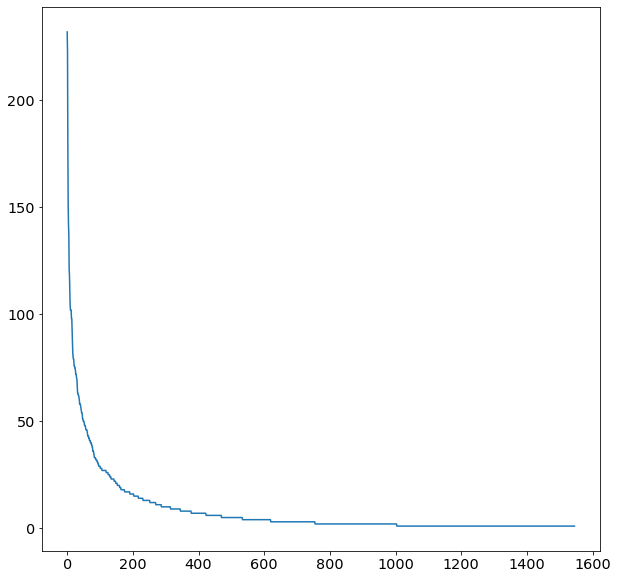

In [16]:
fig = plt.figure()
ax = plt.axes()
x = range(0,word_map.shape[0])
ax.plot(x, word_map['counts'])

I don't want to keep too specific words, so I drope those that are not very frequent. Let's keep first 125 words (this approximately corresponds to the point that is closest to 0 on the plot above).

In [17]:
pass_list = list(word_map['words'].head(125).values)

# Here I create a list of "allowed" keywords and repeat the procedure with creation of the frequency map
# using this as a "pass list".
# I could simply modify the existing list, but I will need it later on.
def get_selected_keywords(d):
    global pass_list
    return get_keywords(d, pass_list = pass_list)


vectorizer = CountVectorizer(lowercase=True, stop_words="english", analyzer=get_selected_keywords)
response = vectorizer.fit_transform(descriptions)

Let's see how many keywords correspond to each product

(array([1157., 2006., 1492.,  524.,   79.,   13.]),
 array([0.        , 0.83333333, 1.66666667, 2.5       , 3.33333333,
        4.16666667, 5.        ]),
 <a list of 6 Patch objects>)

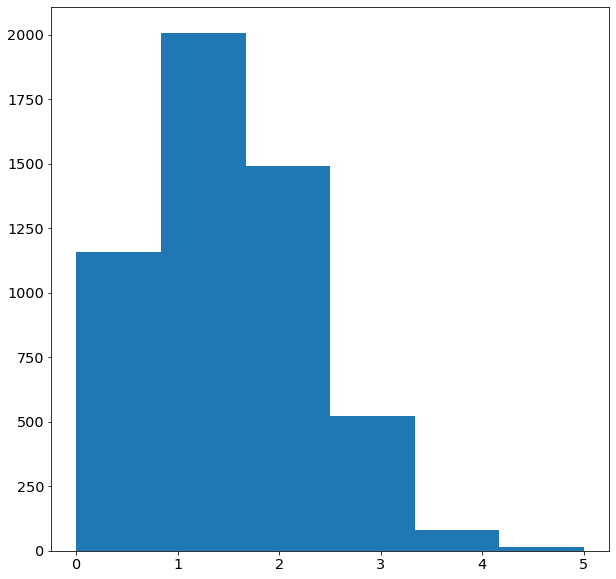

In [18]:
plt.hist(response.toarray().sum(1), bins = 6, )

Ok, now we ahve a lot of products with 0 and 1 keywords. Let's remove them and train clustering on connected words.

In [19]:
cleaned_response = response[response.getnnz(1)>1]

### Hierarchical clustering

We have sparse categorial data that we need to categorise. Let's first try hierarchical clustering with `AgglomerativeClustering` algorithm.

In [20]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)


In [21]:
# We have categorised data, so manhattan affinity seems to be more natural than euclidean. 
# Complete linkage gives better dendrogram in this task
model = AgglomerativeClustering(affinity = 'manhattan',
                                linkage = 'complete',
                                distance_threshold=0,
                                n_clusters = None)

In [22]:
model = model.fit(cleaned_response.toarray())

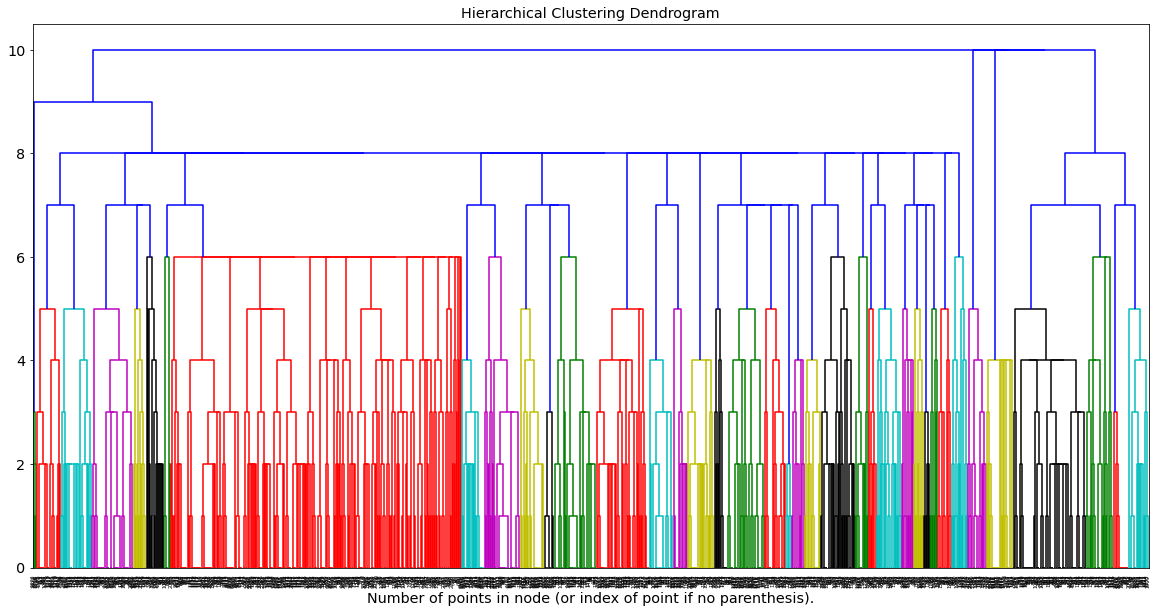

In [23]:
plt.figure(figsize = (20,10))
plt.title('Hierarchical Clustering Dendrogram')
plot_dendrogram(model, truncate_mode='level', p=20)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

Looking at the dendrogram, we have several values to choose from: 4, 5, 19... 
Let's start from the smallest numebr of categories since it's easier to interpret.

In [29]:
#4 5 19 ...
n_clusters = 4
model_final = AgglomerativeClustering(affinity = 'manhattan',
                                       linkage = 'complete',
                                       n_clusters=n_clusters)
model_final.fit(response.toarray())

AgglomerativeClustering(affinity='manhattan', linkage='complete', n_clusters=4)

In [30]:
labels = model_final.labels_

In [31]:
categorised_products = pd.DataFrame({"Description":descriptions,"Category":labels})

In [32]:
categorised_products.groupby("Category").count()

,Description
Category,
0,4726
1,468
2,45
3,32


<Figure size 720x720 with 0 Axes>

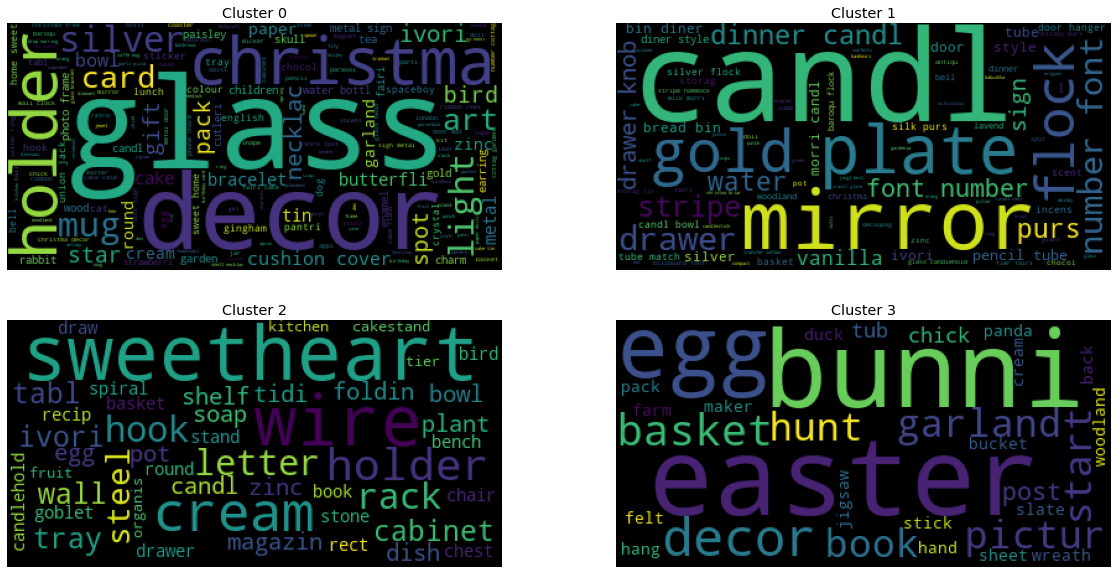

<Figure size 720x720 with 0 Axes>

In [33]:
from wordcloud import WordCloud
plt.figure(figsize=(20,10))
wc = WordCloud()

for num, cluster in enumerate(range(n_clusters)) :
    plt.subplot(2, 2, num+1)
    in_cluster = categorised_products.query("Category == "+str(cluster))
    descs = in_cluster.Description.values
    words = []
    for d in descs:
        words+=get_keywords(d)
    wc.generate(" ".join(words))
    plt.imshow(wc)
    plt.title("Cluster {}".format(cluster))
    plt.axis("off")
plt.figure()


We have two big categories and one "letftower" (note the order o cluster may change once you rerun the code):
* Cluster 0 corrsponds to chirstmas-related gifts
* Cluster 3 corresponds to easter gifts
* Cluster 1 table decor
* Cluster 2 is "leftower"
I don't feel that this clustering adds some meaningful information so let's see if we can get anything better with other algorithms.

### KModes

In [28]:
from kmodes.kmodes import KModes
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
x = list(range(10, 100, 10))

chosen_response = cleaned_response.toarray()

for n_clusters in x:
    kmodes = KModes(n_clusters = n_clusters)
    clusters = kmodes.fit_predict(chosen_response, categorical = range(chosen_response.shape[1]))
    silhouette_avg = silhouette_score(chosen_response, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)


For n_clusters = 10 The average silhouette_score is : 0.028931327307174848
For n_clusters = 20 The average silhouette_score is : 0.03067201108557618
For n_clusters = 30 The average silhouette_score is : 0.07794234339180656
For n_clusters = 40 The average silhouette_score is : 0.13385536048670138
For n_clusters = 50 The average silhouette_score is : 0.1506477956773396
For n_clusters = 60 The average silhouette_score is : 0.210357864146758
For n_clusters = 70 The average silhouette_score is : 0.20893378625131118
For n_clusters = 80 The average silhouette_score is : 0.21859146764623716
For n_clusters = 90 The average silhouette_score is : 0.22564581287762872


We are getting too many clusters. Moreover, the algorithm perormance significantly drops fro high number of clusters. Let's do the final attempt with yet another algorithm

### KMeans

KMeans isn't suited for categorical data, so let's get numerical ones.We can us TF-IDF metric here.

In [34]:
tfidfvectorizer = TfidfVectorizer(lowercase=True, stop_words="english", analyzer=get_keywords)
tfidf_response = tfidfvectorizer.fit_transform(descriptions)

In [39]:
svd = TruncatedSVD(n_components = 125)
normalizer = Normalizer(copy=False)

response_transfomed = svd.fit_transform(tfidf_response)
response_transfomed = normalizer.fit_transform(tfidf_response)

In [49]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
# I want to monitor average silhouette score and distortions ( to find shoulder)
distortions = []
silhouette = []
numbers_of_clusters = range(10, 1010, 100)

for n_clusters in numbers_of_clusters:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 50)
    clusters = kmeans.fit_predict(response_transfomed)
    silhouette_avg = silhouette_score(response_transfomed, clusters)
    silhouette.append(silhouette_avg)
    distortions.append(sum(np.min(cdist(response_transfomed.toarray(), kmeans.cluster_centers_, 
                      'euclidean'),axis=1)) / response_transfomed.shape[0]) 
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 10 The average silhouette_score is : 0.034497325065057836
For n_clusters = 110 The average silhouette_score is : 0.1317354977257799
For n_clusters = 210 The average silhouette_score is : 0.16398063905607044
For n_clusters = 310 The average silhouette_score is : 0.19010694111000215
For n_clusters = 410 The average silhouette_score is : 0.20949032056583858
For n_clusters = 510 The average silhouette_score is : 0.23738327379713664
For n_clusters = 610 The average silhouette_score is : 0.2575342433991283
For n_clusters = 710 The average silhouette_score is : 0.2793408777397213
For n_clusters = 810 The average silhouette_score is : 0.2944697869328058
For n_clusters = 910 The average silhouette_score is : 0.3154202596098619


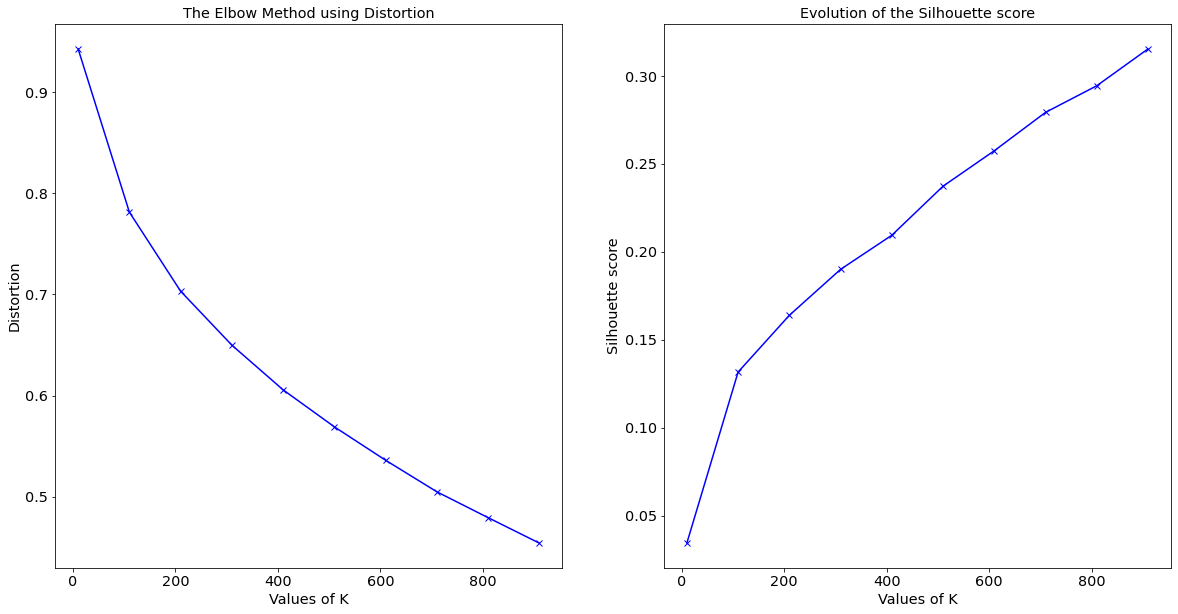

In [56]:
plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.plot(numbers_of_clusters, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.subplot(1,2,2)
plt.plot(numbers_of_clusters, silhouette, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Silhouette score') 
plt.title('Evolution of the Silhouette score') 
plt.show() 
        

Just like with `KModes`, we are getting way too many clusters and we don't have any Elbow to decide how manu clusters do we need.

### Clustering by description: conclusion

While it is possible to create some clusters of products using their decsription, they are too numerous and/or hard to interpret. What's more important, since the company sells quite specialised items (oll-ocation gifts), categorisation by the type of product may be not that interesting for categorisation of the customers. So for now I would abandon this idea, keeping in mind that this is a possible point of improvement of analysis.

## Clustering by price

Given that the products are quite homogenous, let's simply categorise them by price.

In [43]:
sales_data['Price'].describe()

count    802695.000000
mean          2.930540
std           4.275824
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max         649.500000
Name: Price, dtype: float64

Text(0, 0.5, 'Occurences in sales database')

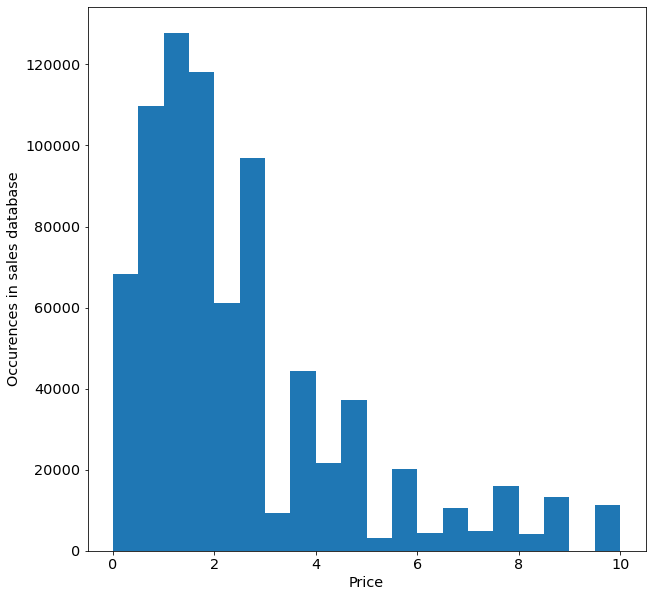

In [44]:
plt.hist(sales_data['Price'], range = [0, 10], bins = 20)
plt.xlabel("Price")
plt.ylabel("Occurences in sales database")

Let's use the following price baskets:
 * [0-0.5) GBP 
 * [0.5-1) GBP 
 * [1-3) GBP 
 * [3-10) GBP
 * More than 10 GBP

In [45]:
def get_price_basket(price):
    if (price>=0.5) and (price < 1):
        return 1
    if (price>=1) and (price < 3):
        return 2
    if (price>=3) and (price < 10):
        return 3
    if (price>=10):
        return 4
    return 0

sales_data['Price_basket'] =  sales_data['Price'].apply(get_price_basket)

In [46]:
sales_data['Product_0'] =  (sales_data['Price_basket'] == 0).astype(int)*sales_data['Quantity']
sales_data['Product_1'] =  (sales_data['Price_basket'] == 1).astype(int)*sales_data['Quantity']
sales_data['Product_2'] =  (sales_data['Price_basket'] == 2).astype(int)*sales_data['Quantity']
sales_data['Product_3'] =  (sales_data['Price_basket'] == 3).astype(int)*sales_data['Quantity']
sales_data['Product_4'] =  (sales_data['Price_basket'] == 4).astype(int)*sales_data['Quantity']
sales_data.to_hdf("for_categorisation_sales.hdf",key="df")

/Users/ilya/Env_For_All/lib/python3.7/site-packages/pandas/core/generic.py:2446: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed-integer,key->block3_values] [items->Index(['StockCode', 'Description', 'Country'], dtype='object')]

  encoding=encoding,
